![alt text](<logoET.png>)

# ET in Italia: Scienza e Tecnologia
Assisi, 20-23 February 2024


### GWFish Tutorial

## Settings for Google Colab

In [ ]:
#! pip install -q git+https://github.com/janosch314/GWFish.git

In [ ]:
#! pip install -q lalsuite

In [ ]:
#! pip install -q corner

**Note 1**: in Google Colab remember to **restart the kernel runtime** after installation

**Note 2**: GWFish uses LALSimulation, so the package needs to be installed separately from GWFish

## Import packages

In [3]:
import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
from astropy.cosmology import Planck18

In [4]:
#GWFish_path = '/usr/local/lib/python3.10/dist-packages/GWFish/'
GWFish_path = '../../GWFish/GWFish/'


## On your PC
To make GWFish modules available from any location in your PC, after clonig the repository
```
git clone https://github.com/janosch314/GWFish/tree/main
```
execute the command
```
pip install .
```

# Single Event Analysis: GW170817-like

## Initialize GWFish

Here we are using the **GW180817** BNS event as it would have been seen with a triangular shape ET located in Sardinia.

* We need to specify the population type (BNS or BBH), then the detectors and the network
* The choice of the waveform approximant can be done from all the availbale waveforms from **LALSimulation**
* All the detectors characteristics are specified in the **detectors.yaml** file
* For a more realistic analysis we can include the **duty cycle** of the detectors using `duty_cycle = True`

In [5]:
# The detector names can be accessed in detectors.yaml file
# One can list as many detectors as they want: ['H1', 'L1', 'V1', 'CE', 'ET']
detectors = ['ET']
# The networks are the combinations of detectors that will be used for the analysis
# The detection_SNR is the minimum SNR for a detection:
#   --> The first entry specifies the minimum SNR for a detection in a single detector
#   --> The second entry specifies the minimum network SNR for a detection
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.),
                               config = os.path.join(GWFish_path,'detectors.yaml'))


# We choose a waveform approximant suitable for BNS analysis
# In this case we are taking into account tidal polarizability effects
waveform_model = 'IMRPhenomD_NRTidalv2'

### Injections

We can analyze single events or entire populations (see below). Here consider the GW170817 event. 

The parameters need to passed as a **DataFrame** with the following nomenclature:
- `mass_1`: primary mass of the binary in Msol (in source frame)
- `mass_2`: secondary mass of the binary in Msol (in source frame)
- `redshift`: the redshift of the merger
- `luminosity_distance`:  the luminosity distance of the merger in Mpc, usually one sets the redshift and calculates the corresponding luminosity distance using Planck18 cosmology (see below)
- `theta_jn`: the inclination angle between the line of observation and the perpendicular to the binary plane in rad
- `dec`: declination angle in rad
- `ra`: right ascension in rad
- `psi`: the polarization angle in rad
- `phase`: the initial phase of the merger in rad
- `geocent_time`: merger time as GPS time
- `a_1`: dimensionless spin parameter of primary component
- `a_2`: dimensionless spin parameter of secondary component
- `lambda_1`: tidal polarizabilty of primary component
- `lambda_2`: tidal polarizabilty of secondary component

In [6]:
z = np.array([0.00980])

parameters = {
    'mass_1': np.array([1.4957673]), 
    'mass_2': np.array([1.24276395]), 
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'theta_jn': np.array([2.545065595974997]),
    'ra': np.array([3.4461599999999994]),
    'dec': np.array([-0.4080839999999999]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1187008882.4]),
    'a_1':np.array([0.005136138323169717]), 
    'a_2':np.array([0.003235146993487445]), 
    'lambda_1':np.array([368.17802383555687]), 
    'lambda_2':np.array([586.5487031450857])}
parameters = pd.DataFrame(parameters)
parameters

,mass_1,mass_2,redshift,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2,lambda_1,lambda_2
0,1.495767,1.242764,0.0098,43.747554,2.545066,3.44616,-0.408084,0.0,0.0,1.187009e+09,0.005136,0.003235,368.178024,586.548703


### Initialize Network

If we want to compute the Fisher matrix we need to specify the parameters in the detector network settigs. Moreover, we need to specify what is the minimum network SNR for Fisher analysis (the fiducial value is set to SNR = 8.)

In [80]:
# The fisher parameters are the parameters that will be used to calculate the Fisher matrix
# and on which we will calculate the errors
fisher_parameters = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']


### Calculate SNR and Errors for 1 event

In [16]:
network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network,
        parameters,
        fisher_parameters=fisher_parameters, 
        waveform_model = waveform_model 
    )


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


In [9]:
print('The network SNR of the event is ', network_snr)

The network SNR of the event is  [636.21570902]


In [17]:
print('The sky localization of the event is ', sky_localization)

The sky localization of the event is  [3.66841494e-05]


In [22]:
# Choose percentile factor of sky localization and pass from rad2 to deg2
percentile = 90.
sky_localization_90cl = sky_localization * gw.fishermatrix.sky_localization_percentile_factor(percentile)
sky_localization_90cl

array([0.55458664])

In [84]:
np.squeeze(parameter_errors)[0]


8.2654305453764e-06

In [92]:
parameter_errors_dict = {}
for i, parameter in enumerate(fisher_parameters):
    parameter_errors_dict['err_' + parameter] = np.squeeze(parameter_errors)[i]

print('The parameter errors of the event are ')
parameter_errors_dict

The parameter errors of the event are 


{'err_mass_1': 8.2654305453764e-06,
 'err_mass_2': 6.797942793746427e-06,
 'err_luminosity_distance': 2.027444376970995,
 'err_theta_jn': 0.07113611786094015,
 'err_dec': 0.0032706449161201746,
 'err_ra': 0.003889731638389328,
 'err_psi': 0.11851067435303207,
 'err_phase': 0.2396071231729874,
 'err_geocent_time': 7.947010237620275e-05,
 'err_a_1': 0.07077956506119198,
 'err_a_2': 0.08868970564104596,
 'err_lambda_1': 3849.511611792408,
 'err_lambda_2': 6926.096342252823}

### Plot Signal

In [46]:
waveform_class = gw.waveforms.LALFD_Waveform
data_params = {
        'frequencyvector': network.detectors[0].frequencyvector,
        'f_ref': 50.
    }
waveform_obj = waveform_class(waveform_model, parameters.iloc[0], data_params)
wave = waveform_obj()
t_of_f = waveform_obj.t_of_f

signal = gw.detection.projection(parameters.iloc[0], network.detectors[0], wave, t_of_f)

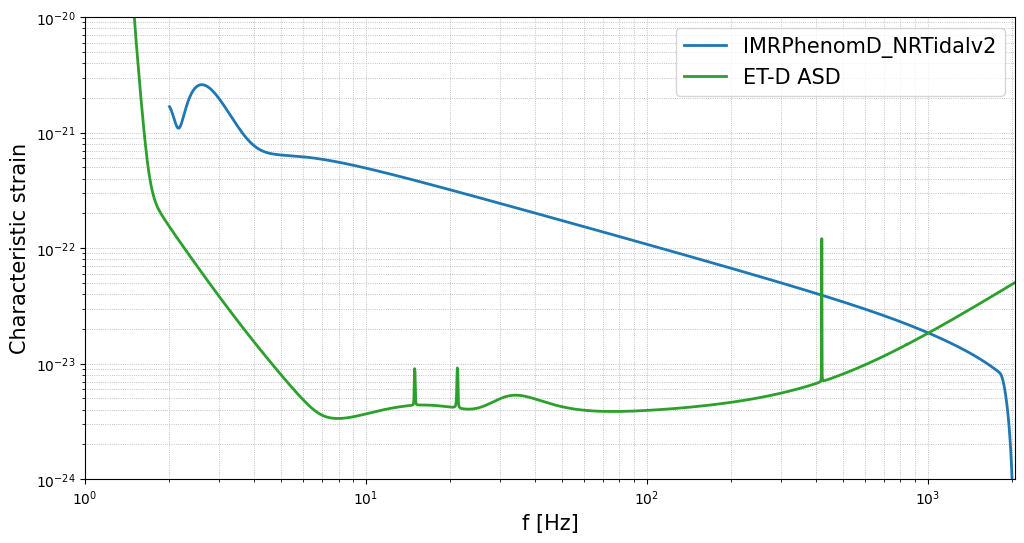

In [95]:
# The projected amplitude is stored in the signal variable
# We have 3 columns as ET is made of 3 detectors
signal1, signal2, signal3 = signal[:, 0], signal[:, 1], signal[:, 2]
signal_ampl = np.sqrt(np.abs(signal1)**2. + np.abs(signal2)**2. + np.abs(signal3)**2.)

psd_et_D = np.loadtxt(os.path.join(GWFish_path,'detector_psd/ET_psd.txt'), usecols=[0,1])
frequencyvector = network.detectors[0].frequencyvector[:, 0]

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(frequencyvector, 2. * np.sqrt(frequencyvector) * signal_ampl, 
        linewidth=2., label='%s' %(waveform_model))
ax.plot(psd_et_D[:,0], np.sqrt(psd_et_D[:,0]) * np.sqrt(psd_et_D[:,1]), linewidth = 2.0, color = 'C2', label = 'ET-D ASD')

ax.set_xlim(1.,frequencyvector[-1])
ax.set_ylim(1e-24, 1e-20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel(r'Characteristic strain', fontsize=15)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend(loc='upper right', fontsize=15, ncol=1, fancybox=True)

plt.show()

### A note on characteristic strain

The characteristic strain is a particular combination of signal/ASD with frequency so that the output is adimensional and the area in between the signal and the detector's densitivity curve can be interpreted as SNR:

$$
SNR^2 = 4\int\frac{h(f)h^*(f)}{S_n}df
$$

Therefore:

$$
h_c = 2f|h| \quad \text{and} \quad S_n = \sqrt{f}\sqrt{PSD}
$$

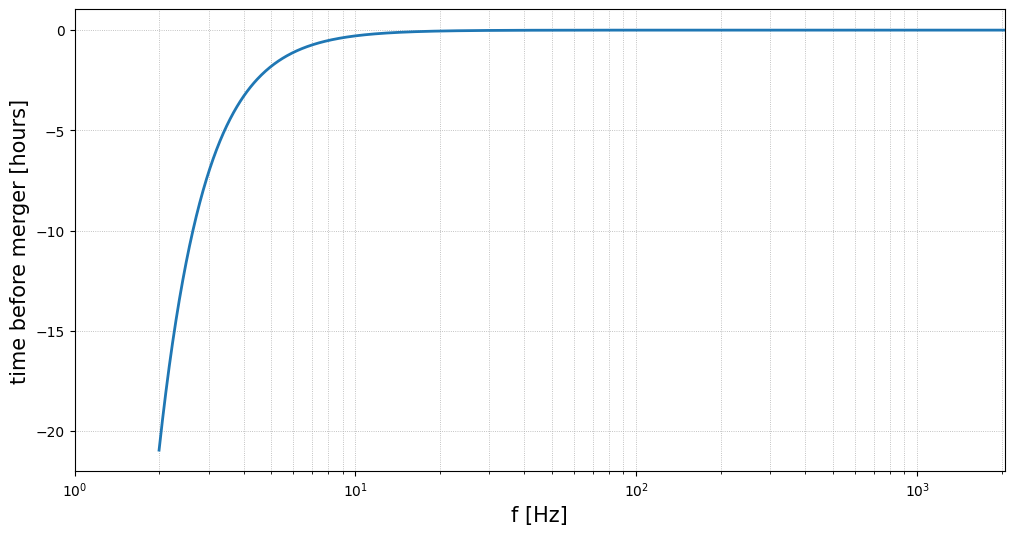

In [77]:
# Plot the time before merger as a function of frequency
fig, ax = plt.subplots(figsize = (12,6))
conv_to_hours = 3600
ax.plot(frequencyvector, (t_of_f - parameters['geocent_time'].iloc[0]) / conv_to_hours, linewidth = 2.)

ax.set_xlim(1.,frequencyvector[-1])
ax.set_xscale('log')
ax.set_xlabel('f [Hz]', fontsize = 15)
ax.set_ylabel(r'time before merger [hours]', fontsize=15)
plt.grid(linestyle = 'dotted', linewidth = '0.6', which = 'both')

plt.show()

## Fisher matrix and error analysis

In [ ]:
errors = pd.read_csv('Errors_ET_%s_SNR%s.txt'%(population, threshold_SNR[1]), delimiter = ' ')

fishers = np.load('Fishers_ET_%s_SNR%s.npy' %(population, threshold_SNR[1]))
fisher_matrix = fishers[0, :, :]
print('We expect Delta dL/dL to scale as 1/SNR')
print('fisher matrix dL-dL: ', fisher_matrix[2, 2])
print('(SNR/dL)^2: ', (errors['network_SNR'].iloc[0] / errors['luminosity_distance'].iloc[0])**2)
print(errors.iloc[0])

inv_fishers = np.load('Inv_Fishers_ET_%s_SNR%s.npy' %(population, threshold_SNR[1]))
cov_matrix = inv_fishers[0, :, :]

In [ ]:
sky_loc_conv = 4.6 * (180. / np.pi)**2
print('Sky localization (in deg2) =', sky_loc_conv * errors['err_sky_location'].iloc[0])

## Corner plot

In [ ]:
CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 12), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )
corner_lbs = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$', '$D_l$ [Mpc]',
                '$\iota$ [rad]', '$DEC$ [rad]', '$RA$ [rad]', '$\Psi$ [rad]',
                 '$phase$', '$t_c$', '$a_1$', '$a_2$', '$\Lambda_1$', '$\Lambda_2$']
mean_values = [parameters['mass_1'].iloc[0], parameters['mass_2'].iloc[0], 
               parameters['luminosity_distance'].iloc[0],
               parameters['theta_jn'].iloc[0], parameters['dec'].iloc[0], 
               parameters['ra'].iloc[0], parameters['psi'].iloc[0],
               parameters['phase'].iloc[0], parameters['geocent_time'].iloc[0],
               parameters['a_1'].iloc[0], parameters['a_2'].iloc[0],
               parameters['lambda_1'].iloc[0], parameters['lambda_2'].iloc[0]]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))
fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    **CORNER_KWARGS)
plt.show()

# BBH Population Analysis

* The `threshold_SNR` specifies in the first entry what is the minimum SNR for a detector to be included in the network, while the second entry is the lower threshold for the network SNR so that the Fisher matrix of the event is calculated
* If we want to calculate the uncertainties on the injected parameters values we need to specify `calculate_errors = True` and list the parameters to include in the Fisher analysis `fisher_parameters = ['...']`
* For a more realistic analysis we can include the duty cycle of the detectors using `duty_cycle = True`

## Create your BBH population

In [ ]:
population = 'BNS' # or 'BBH'
detectors = ['ET']
networks = '[[0]]'

detectors_ids = detectors
networks_ids = json.loads(networks)
ConfigDet = os.path.join(GWFish_path,'detectors.yaml')

waveform_model = 'lalsim_TaylorF2'
threshold_SNR = np.array([0., 12.])
calculate_errors = True
fisher_parameters = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'geocent_time', 'phase', 'a_1', 'a_2', 'lambda_1', 'lambda_2']
duty_cycle = True

np.random.seed(0) # to make the results reproducible

waveform_model = 'lalsim_IMRPhenomD_NRTidalv2'

In [ ]:
df = pd.read_csv(data, delimiter=',')
print(df.keys())
pop_parameters = {
    'mass_1': df['m1_src'].to_numpy(), 
    'mass_2': df['m2_src'].to_numpy(), 
    'redshift': df['z'].to_numpy(),
    'luminosity_distance': Planck18.luminosity_distance(df['z'].to_numpy()).value,
    'theta_jn': df['iota'].to_numpy(),
    'ra': df['phi'].to_numpy(),
    'dec': df['dec'].to_numpy(), 
    'psi': df['psi'].to_numpy(),
    'phase': df['Phicoal'].to_numpy(),
    'geocent_time': df['tGPS'].to_numpy(),
    'a_1':df['chi1z'].to_numpy(), 
    'a_2':df['chi2z'].to_numpy(), 
    'lambda_1':df['Lambda1'].to_numpy(), 
    'lambda_2':df['Lambda2'].to_numpy()}

pop_parameters = pd.DataFrame(pop_parameters)

network = gw.detection.Network(detectors_ids, detection_SNR=threshold_SNR, parameters=pop_parameters,
                                   fisher_parameters=fisher_parameters, config=ConfigDet)
pop_parameters

In [ ]:
for k in tqdm(np.arange(len(pop_parameters))):
  parameter_values = pop_parameters.iloc[k]

  networkSNR_sq = 0
  for d in np.arange(len(network.detectors)):
    data_params = {
        'frequencyvector': network.detectors[d].frequencyvector,
        'f_ref': 50.
    }
    waveform_obj = waveform_class(waveform_model, parameter_values, data_params)
    wave = waveform_obj()
    t_of_f = waveform_obj.t_of_f

    signal = gw.detection.projection(parameter_values, network.detectors[d], wave, t_of_f)

    SNRs = gw.detection.SNR(network.detectors[d], signal, duty_cycle=duty_cycle)
    networkSNR_sq += np.sum(SNRs ** 2)
    network.detectors[d].SNR[0] = np.sqrt(np.sum(SNRs ** 2))

    if calculate_errors:
        network.detectors[d].fisher_matrix[0, :, :] = \
            gw.fishermatrix.FisherMatrix(waveform_model, parameter_values, fisher_parameters, network.detectors[d], waveform_class=waveform_class).fm

network.SNR[0] = np.sqrt(networkSNR_sq)

gw.detection.analyzeDetections(network, pop_parameters, population, networks_ids)
if calculate_errors:
    gw.fishermatrix.analyzeFisherErrors(network, pop_parameters, fisher_parameters, population, networks_ids)


In [ ]:
errors = pd.read_csv('Errors_ET_%s_SNR%s.txt' %(population, threshold_SNR[1]), delimiter = ' ')
print(errors.keys())

## Plots of injected data

In [ ]:
plt.hist(errors['network_SNR'], bins = 25, alpha = 0.5)
plt.xlabel('SNR')
plt.ylabel('number of events')
plt.grid(linestyle='dotted', linewidth='0.6', which='both')

plt.show()

In [ ]:
plt.hist(errors['mass_1'], bins = 25, label = 'mass_1', alpha= 0.5)
plt.hist(errors['mass_2'], bins = 25, label = 'mass_2', alpha= 0.5)
plt.legend()
plt.xlabel('mass [$M_{\odot}$]')
plt.ylabel('number of events')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

In [ ]:
# Cut the results to max sky_loc = whole_sky
whole_sky = 4 * np.pi
errors = errors.loc[errors['err_sky_location'] <= whole_sky]

sky_loc_conv = 4.6 * (180. / np.pi)**2
sc = plt.scatter(errors['err_luminosity_distance']/errors['luminosity_distance'],
                 sky_loc_conv * errors['err_sky_location'],
                 c = errors['network_SNR'], cmap = 'inferno')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\Delta d_L/d_L$')
plt.ylabel('$\Delta \Omega_{90}$')
plt.colorbar(sc, label = 'SNR')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

In [ ]:
plt.hist(errors['err_theta_jn']/errors['theta_jn'], bins = np.logspace(-2, 2, 50), alpha = 0.5)
plt.xscale('log')
plt.xlabel('$\Delta \iota/\iota$')
plt.ylabel('number of events')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

In [ ]:
plt.hist(errors['err_luminosity_distance']/errors['luminosity_distance'], bins = np.logspace(-2, 2, 50), alpha = 0.5)
plt.xscale('log')
plt.xlabel('$\Delta d_L/d_L$')
plt.ylabel('number of events')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()